In [1]:
%matplotlib notebook

from Inn2 import RadynversionNet, AtmosData, RadynversionTrainer
import loss as Loss
import pickle
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import torch
import torch.optim
import torch.utils.data
from torch.distributions.multivariate_normal import MultivariateNormal

from time import time

dev = 'cuda' if torch.cuda.is_available() else 'cpu'
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# dataLocation1 = '/local0/scratch/HAlphaGridExportStatic/DoublePicoMegaPickle50.pickle'
# dataLocation1a = '/local0/scratch/HAlphaGridExportStatic/DoublePicoMegaMassPickle50.pickle'
# dataLocation3 = '/local0/scratch/HAlphaGridExportStatic/MiniBalancedTraining.pickle'
# dataLocation2 = '/local0/scratch/HAlphaGridExportStatic/TestPickle50.pickle'
# dataLocation = '/local0/scratch/Chris/DoublePicoMegaPickle50.pickle'
# dataLocation = 'G:\\DoublePicoMegaPickle.pickle'
balancedData = 'MiniBalancedTraining.pickle'

# data = AtmosData([dataLocation1, dataLocation2], resampleWl=30)
# data = AtmosData([dataLocation1], resampleWl=30)
data = AtmosData([balancedData], resampleWl=30)
# data = AtmosData([balancedData], resampleWl=30)
data.split_data_and_init_loaders(500)

In [3]:
inRepr = [('ne', data.ne.shape[1]), ('temperature', data.temperature.shape[1]), ('vel', data.vel.shape[1]), ('!!PAD',)]
outRepr = [('LatentSpace', int(data.ne.shape[1]*3)), ('!!PAD',), ('Halpha', data.lines[0].shape[1]), ('Ca8542', data.lines[1].shape[1])]
model = RadynversionNet(inRepr, outRepr, dropout=0.00, zeroPadding=0, minSize=384, numInvLayers=5)

Node Inv0 has following input dimensions:
	 Output #0 of node Input (0-pad extra channels): (384,)

Node Permute0 has following input dimensions:
	 Output #0 of node Inv0: (384,)

Node Inv1 has following input dimensions:
	 Output #0 of node Permute0: (384,)

Node Permute1 has following input dimensions:
	 Output #0 of node Inv1: (384,)

Node Inv2 has following input dimensions:
	 Output #0 of node Permute1: (384,)

Node Permute2 has following input dimensions:
	 Output #0 of node Inv2: (384,)

Node Inv3 has following input dimensions:
	 Output #0 of node Permute2: (384,)

Node Permute3 has following input dimensions:
	 Output #0 of node Inv3: (384,)

Node Inv4 has following input dimensions:
	 Output #0 of node Permute3: (384,)

Node Output has following input dimensions:
	 Output #0 of node Inv4: (384,)



In [4]:
trainer = RadynversionTrainer(model, data, dev)
trainer.training_params(2000, lr=1.5e-3, zerosNoiseScale=5e-2, wPred=4000.0, wLatent=900.0, wRev=1000.0,
#                         loss_latent=Loss.mmd_multiscale_on(dev, alphas=[3, 4, 6, 9, 16]),
                        loss_latent=Loss.mmd_multiscale_on(dev, alphas=[5, 0]),
#                         loss_backward=Loss.mmd_multiscale_on(dev, alphas=[4, 5, 6, 12, 30]),
                        loss_backward=Loss.mmd_multiscale_on(dev, alphas=[2.0]),
                        loss_fit=Loss.mse)
totalEpochs = 0

In [5]:
import os
def load_checkpoint(filename):
        if os.path.isfile(filename):
            print("=> loading checkpoint '{}'".format(filename))
            checkpoint = torch.load(filename)
            totalEpochs = checkpoint['epoch']
            model.load_state_dict(checkpoint['state_dict'])
            trainer.optim.load_state_dict(checkpoint['optimizer'])
            trainer.scheduler.load_state_dict(checkpoint['scheduler'])
            print("=> loaded checkpoint '{}' (epoch {})"
                  .format(filename, checkpoint['epoch']))
        else:
            print("=> no checkpoint found at '{}'".format(filename))

In [6]:
load_checkpoint('checkpt_11400_25000.pth.tar')
# load_checkpoint('checkpt_mass_800.pth.tar')

=> loading checkpoint 'checkpt_11400_25000.pth.tar'
=> loaded checkpoint 'checkpt_11400_25000.pth.tar' (epoch 11400)


In [7]:
trainer.test(maxBatches=-1)

(0.0001071782,
 0.00074616453,
 tensor([[ 0.4251,  0.3692, -0.9662,  ...,  0.2859,  0.2929,  0.2991],
         [-0.1588, -0.0751, -0.4463,  ...,  0.1623,  0.1619,  0.1665],
         [-0.0506,  0.0630, -0.5281,  ...,  0.2763,  0.2821,  0.2897],
         ...,
         [ 2.0881, -0.4920,  0.8375,  ...,  0.4003,  0.4103,  0.4210],
         [-0.1969,  1.3555, -0.0508,  ...,  0.2133,  0.2199,  0.2235],
         [ 0.0810,  1.4458, -0.0478,  ...,  0.4231,  0.4334,  0.4437]],
        device='cuda:0'),
 tensor([[ 1.4674e+01,  1.3483e+01,  1.2927e+01,  ..., -7.7979e-03,
           9.4722e-04,  1.2628e-03],
         [ 1.4659e+01,  1.3463e+01,  1.2909e+01,  ..., -4.1414e-03,
          -1.1207e-03, -9.7114e-03],
         [ 1.4650e+01,  1.3448e+01,  1.2903e+01,  ..., -2.2771e-03,
          -3.9829e-03, -1.4099e-03],
         ...,
         [ 1.4704e+01,  1.3509e+01,  1.2958e+01,  ...,  6.3256e-03,
          -9.3975e-04,  3.9294e-04],
         [ 1.4666e+01,  1.3487e+01,  1.2920e+01,  ...,  2.0023e-03,


<IPython.core.display.Javascript object>


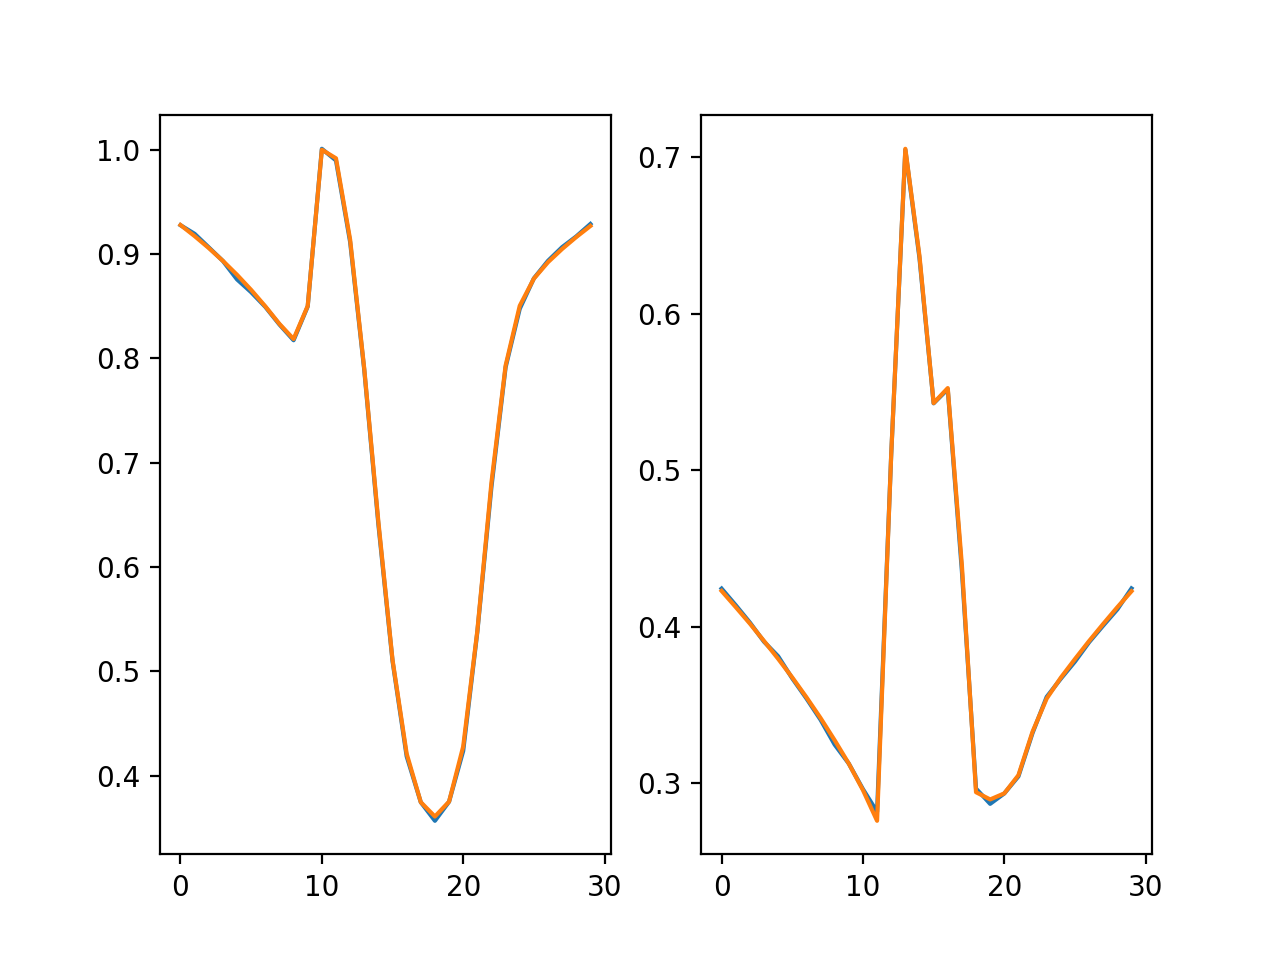

In [9]:
model.eval()
with torch.no_grad():
    x, y = next(iter(data.testLoader))
#     xPad = torch.cat((x, torch.zeros(trainer.miniBatchSize, model.totChannels - model.numXChannels, model.channelSize + model.zeroPadding)), dim=1)
#     xPadShape = xPad.shape
#     xPad = torch.reshape(xPad, (trainer.miniBatchSize, -1))
    x = x.to(dev)
    pad_fn = lambda *x: torch.zeros(*x, device=dev)
    inp = model.inSchema.fill({'ne': x[:, 0] + 0.0 * torch.randn(x[:,0].shape).to(dev),
                                'temperature': x[:, 1] + 0.0 * torch.randn(x[:, 1].shape).to(dev),
                                'vel': x[:, 2]},
                               zero_pad_fn=pad_fn)
    yz = model(inp.to(dev))
    fig, ax = plt.subplots(1,2)
    ax[0].plot(yz[0, model.outSchema.Halpha].cpu().numpy())
    ax[0].plot(y[0, 0].numpy())
    ax[1].plot(yz[0, model.outSchema.Ca8542].cpu().numpy())
    ax[1].plot(y[0, 1].numpy()); fig.show(); fig.canvas.draw()

<IPython.core.display.Javascript object>


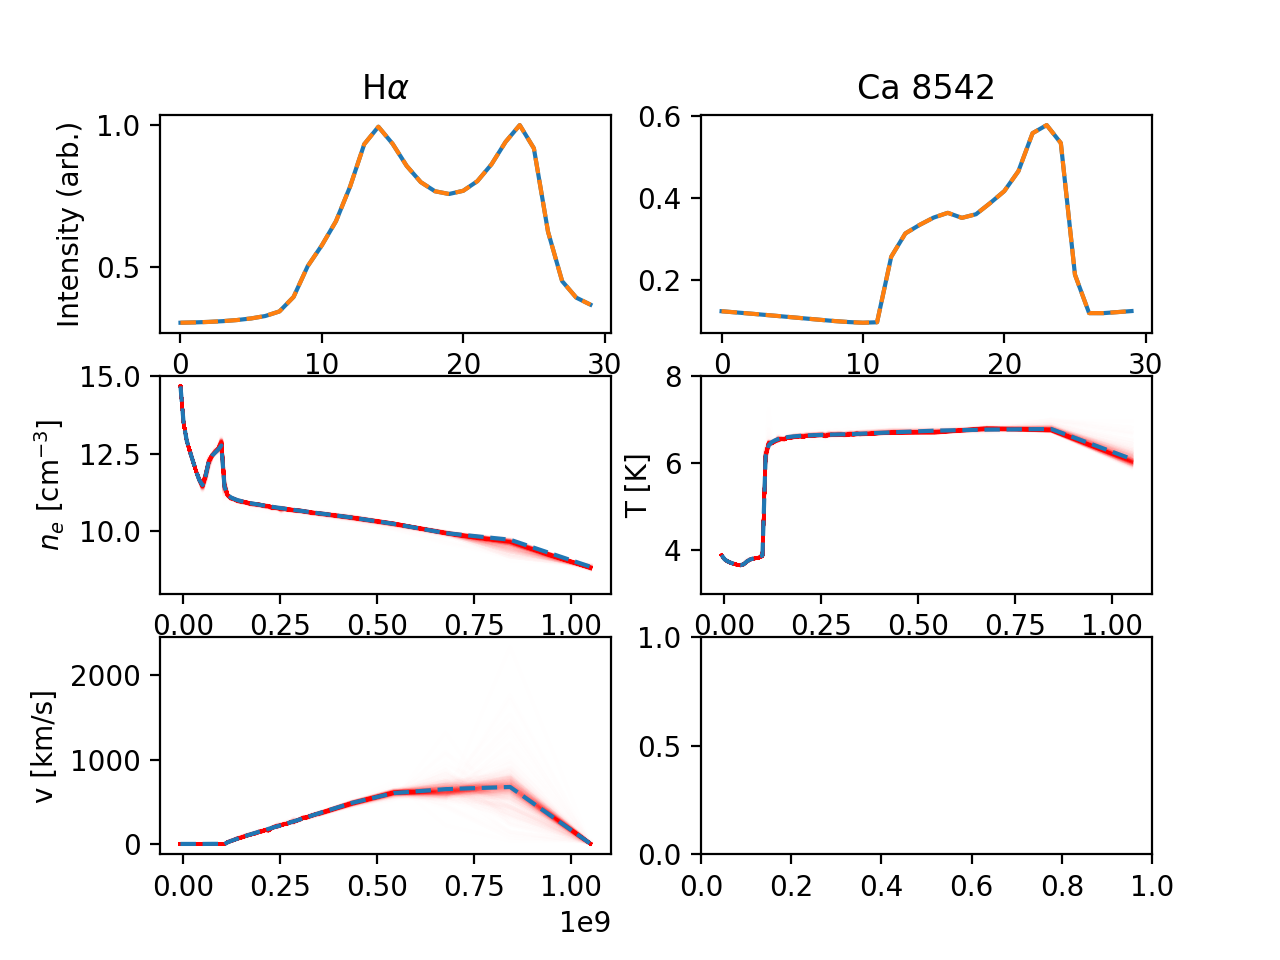

In [10]:
model.eval()
with torch.no_grad():
    x, y = next(iter(data.testLoader))
    a = max(1.0 / x.shape[0], 0.002)
    y = torch.ones_like(y) * y[0, :, :]
    yz = model.outSchema.fill({'Halpha': y[:, 0] + 0.0 * torch.randn(y[:,0].shape), 'Ca8542': y[:, 1] + 0.0 * torch.randn(y[:,1].shape), 'LatentSpace': torch.randn})
    xOut = model(yz.to(dev), rev=True)
    fig, ax = plt.subplots(3,2)
    ax[0, 0].plot(yz[0, model.outSchema.Halpha].cpu().numpy())
    ax[0, 1].plot(yz[0, model.outSchema.Ca8542].cpu().numpy())
    ax[0, 0].plot(y[0, 0].cpu().numpy(), '--')
    ax[0, 1].plot(y[0, 1].cpu().numpy(), '--')
    
    vSign = xOut[:, model.inSchema.vel] / torch.abs(xOut[:, model.inSchema.vel])
    vSign[torch.isnan(vSign)] = 0
    vel = vSign * (10**torch.abs(xOut[:, model.inSchema.vel]) - 1.0)
    
    velInSign = x[0,2] / torch.abs(x[0, 2])
    velInSign[torch.isnan(velInSign)] = 0
    velIn = velInSign * (10**torch.abs(x[0,2]) - 1.0)
    for i in range(x.shape[0]):
        ax[1, 0].plot(data.z.numpy(), xOut[i, model.inSchema.ne].cpu().numpy(), c='r', alpha=a)
        ax[1, 1].plot(data.z.numpy(), xOut[i, model.inSchema.temperature].cpu().numpy(), c='r', alpha=a)
        ax[2, 0].plot(data.z.numpy(), vel[i].cpu().numpy(), c='r', alpha=a)
    ax[1, 0].plot(data.z.numpy(), x[0, 0].cpu().numpy(), '--')
    ax[1, 1].plot(data.z.numpy(), x[0, 1].cpu().numpy(), '--')
    ax[2, 0].plot(data.z.numpy(), velIn.cpu().numpy(), '--')
    
    ax[0, 0].set_title(r'H$\alpha$')
    ax[0, 0].set_ylabel('Intensity (arb.)')
    ax[0, 1].set_title('Ca 8542')
    ax[1, 0].set_ylabel('$n_e$ [cm$^{-3}$]')
    ax[1, 1].set_ylabel('T [K]')
    ax[1,0].set_ylim(8,15)
    ax[1,1].set_ylim(3,8)
    ax[2, 0].set_ylabel('v [km/s]')
    fig.canvas.draw()

In [ ]:
with np.load('2014-09-06_trans.npz') as transData:
    angles = transData['angles']
    translations = transData['translations']

In [11]:
import os
from astropy.io import fits
from skimage.transform import AffineTransform, warp
from matplotlib import patches
caFolder = '/mnt/ca/'
caFolder = '/local1/scratch/armstrong/2014-09-06/ca8542/'
caFiles = sorted([caFolder + f for f in os.listdir(caFolder) if f.endswith('.fits') and not f.startswith('.')])
halphaFolder = '/local1/scratch/armstrong/2014-09-06/Halpha/'
haFiles = sorted([halphaFolder + f for f in os.listdir(halphaFolder) if f.endswith('.fits') and not f.startswith('.')])

haCentralIdx = 7
caCentralIdx = 12
haHW = 1.4
caHW = 1.0

<IPython.core.display.Javascript object>


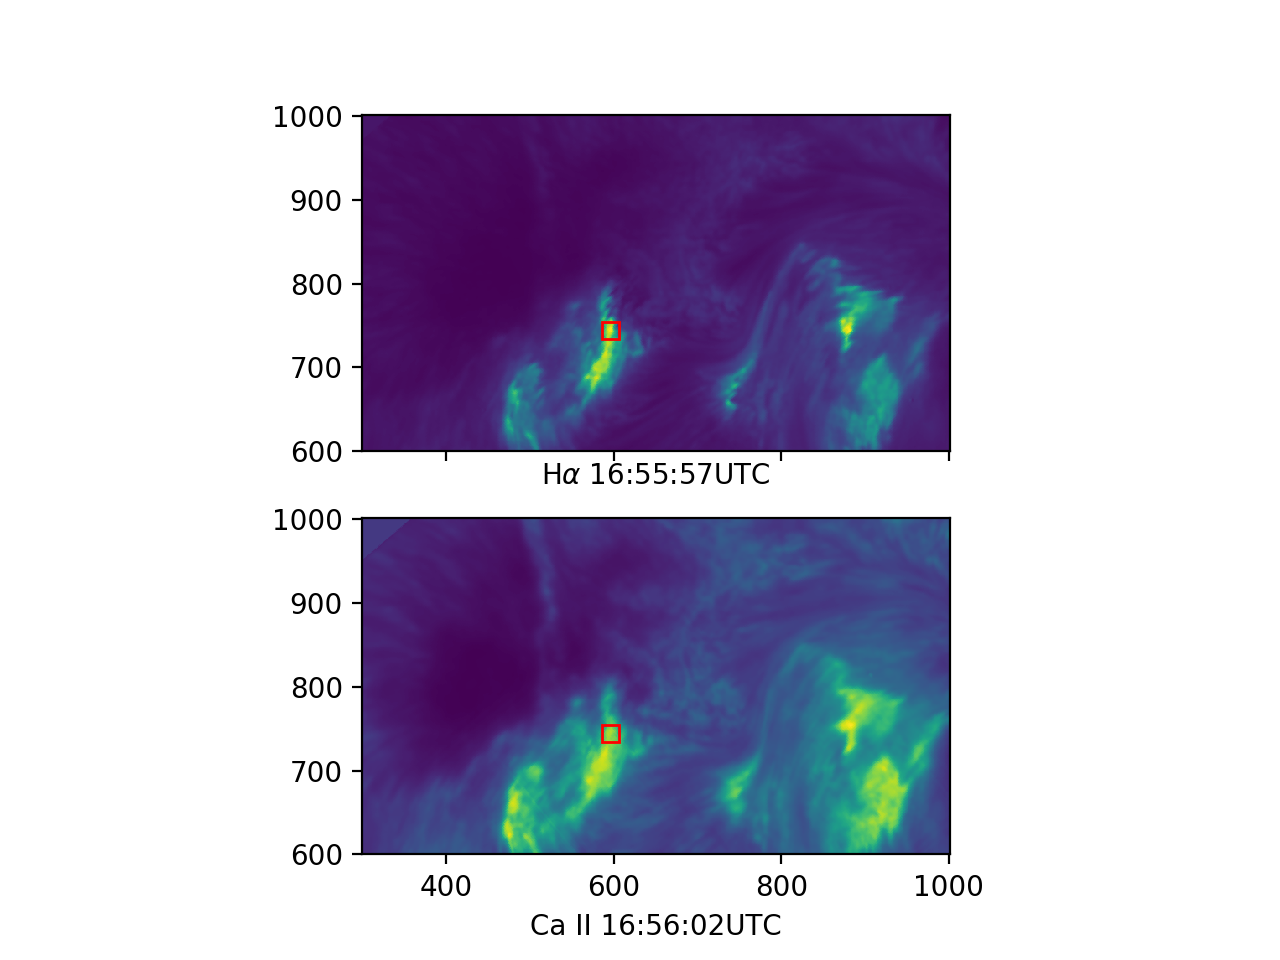

In [21]:
idx = 459
roi_X = (300,1001)
roi_Y = (600,1001)
fine_roi_X = (586,606)
fine_roi_Y = (734,754) #fine region of interest is centred on (881,742)
box_size = (fine_roi_X[-1]-fine_roi_X[0],fine_roi_Y[-1]-fine_roi_Y[0])
ha_patch = patches.Rectangle((fine_roi_X[0],fine_roi_Y[0]),width=box_size[0],height=box_size[1],fill=False,color="r")
ca_patch = patches.Rectangle((fine_roi_X[0],fine_roi_Y[0]),width=box_size[0],height=box_size[1],fill=False,color="r")

with fits.open(haFiles[idx]) as hdu:
    haWl = hdu[1].data
    haCentreWl = hdu[0].header["TWAVE1"]
    ha = hdu[0].data.astype(np.float64)
    haTime = hdu[0].header['DATE-AVG']
    
with fits.open(caFiles[idx]) as hdu:
    caWl = hdu[1].data
    caCentreWl = hdu[0].header["TWAVE1"]
    ca = hdu[0].data.astype(np.float64)
    caTime = hdu[0].header["DATE-AVG"]
    
fig, ax = plt.subplots(2,sharex=True,sharey=True)
ax[0].imshow(ha[haCentralIdx],origin="bottom")
ax[0].set_xlim(roi_X[0],roi_X[-1])
ax[0].set_ylim(roi_Y[0],roi_Y[-1])
ax[0].add_patch(ha_patch)
ax[0].set_xlabel(r"H$\alpha$ "+haTime[11:19]+"UTC")
ax[1].imshow(ca[caCentralIdx],origin="bottom")
ax[1].set_xlim(roi_X[0],roi_X[-1])
ax[1].set_ylim(roi_Y[0],roi_Y[-1])
ax[1].add_patch(ca_patch)
ax[1].set_xlabel("Ca II "+caTime[11:19]+"UTC")
# ax[1].set_xticks([])
# ax[1].set_yticks([]);
fig.savefig("flare_ims.png",dpi=300)

<IPython.core.display.Javascript object>


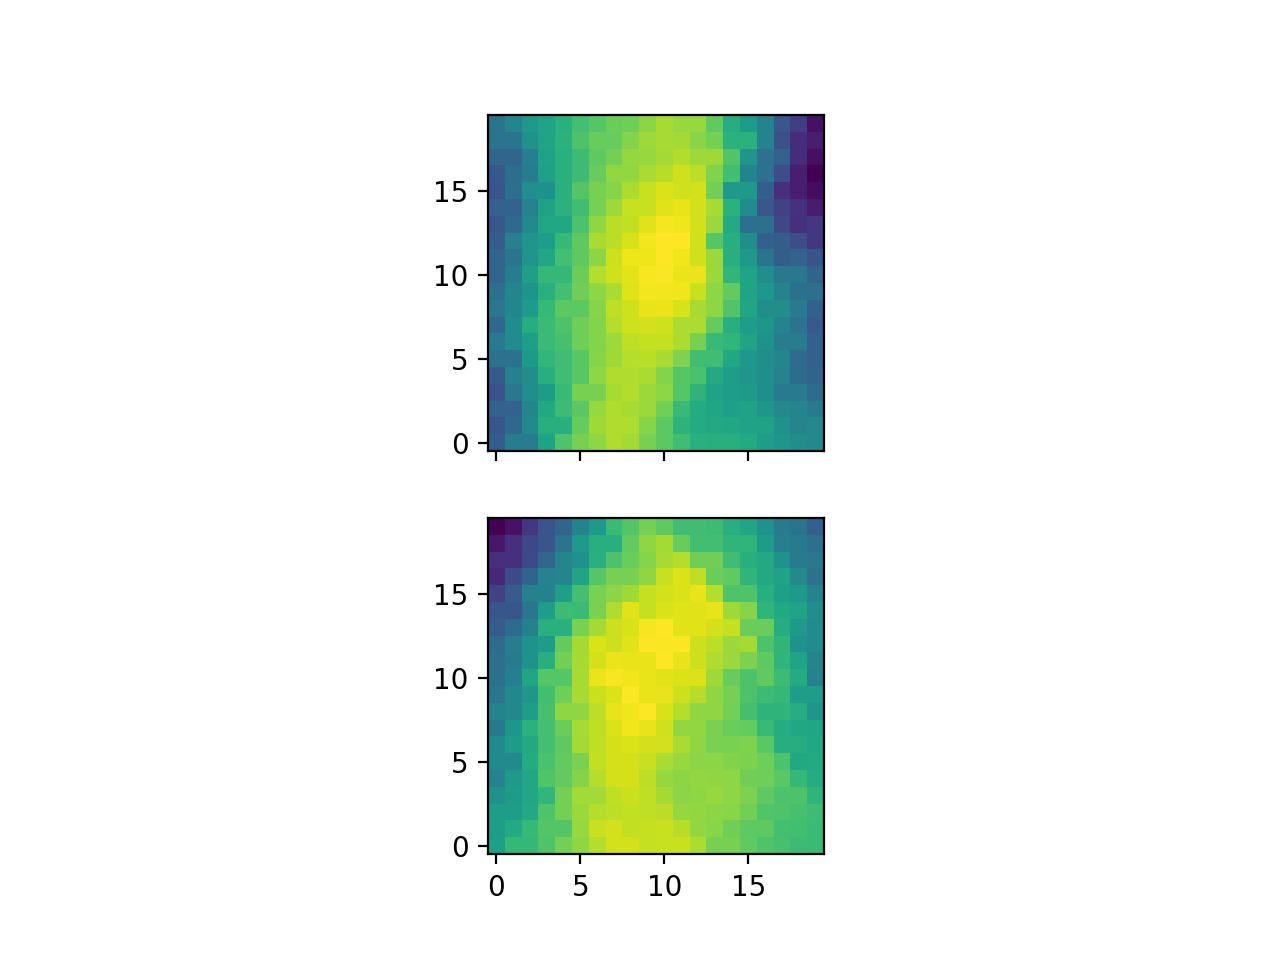

In [22]:
ha_data = ha[np.ix_(range(2*haCentralIdx+1),range(*fine_roi_Y),range(*fine_roi_X))]
ca_data = ca[np.ix_(range(2*caCentralIdx+1),range(*fine_roi_Y),range(*fine_roi_X))]
fig, ax = plt.subplots(2,sharey=True,sharex=True)
ax[0].imshow(ha_data[haCentralIdx],origin="bottom")
ax[1].imshow(ca_data[caCentralIdx],origin="bottom")

In [24]:
grid_1 = (10,10)
grid_2 = (19,19)

In [25]:
from scipy.interpolate import interp1d
wlLength = 30
haFlat = np.reshape(ha_data, (ha_data.shape[0],-1))
caFlat = np.reshape(ca_data, (ca_data.shape[0],-1))

haInput = np.zeros((wlLength, haFlat.shape[1]))
caInput = np.zeros((wlLength, caFlat.shape[1]))

haInputWl = np.linspace(haCentreWl - haHW, haCentreWl + haHW, num=30) 
caInputWl = np.linspace(caCentreWl - caHW, caCentreWl + caHW, num=30) 

for j in range(haFlat.shape[1]):
        haInterp = interp1d(haWl, haFlat[:,j], kind='linear')
        caInterp = interp1d(caWl, caFlat[:,j], kind='linear')
        
        haInput[:,j] = haInterp(haInputWl)
        caInput[:,j] = caInterp(caInputWl)


peakEmission = np.zeros(haFlat.shape[1])
for j in range(haFlat.shape[1]):
        peakEmission[j] = max(np.amax(haInput[:,j]), np.amax(caInput[:,j]))
        haInput[:,j] /= peakEmission[j]
        caInput[:,j] /= peakEmission[j]

<IPython.core.display.Javascript object>


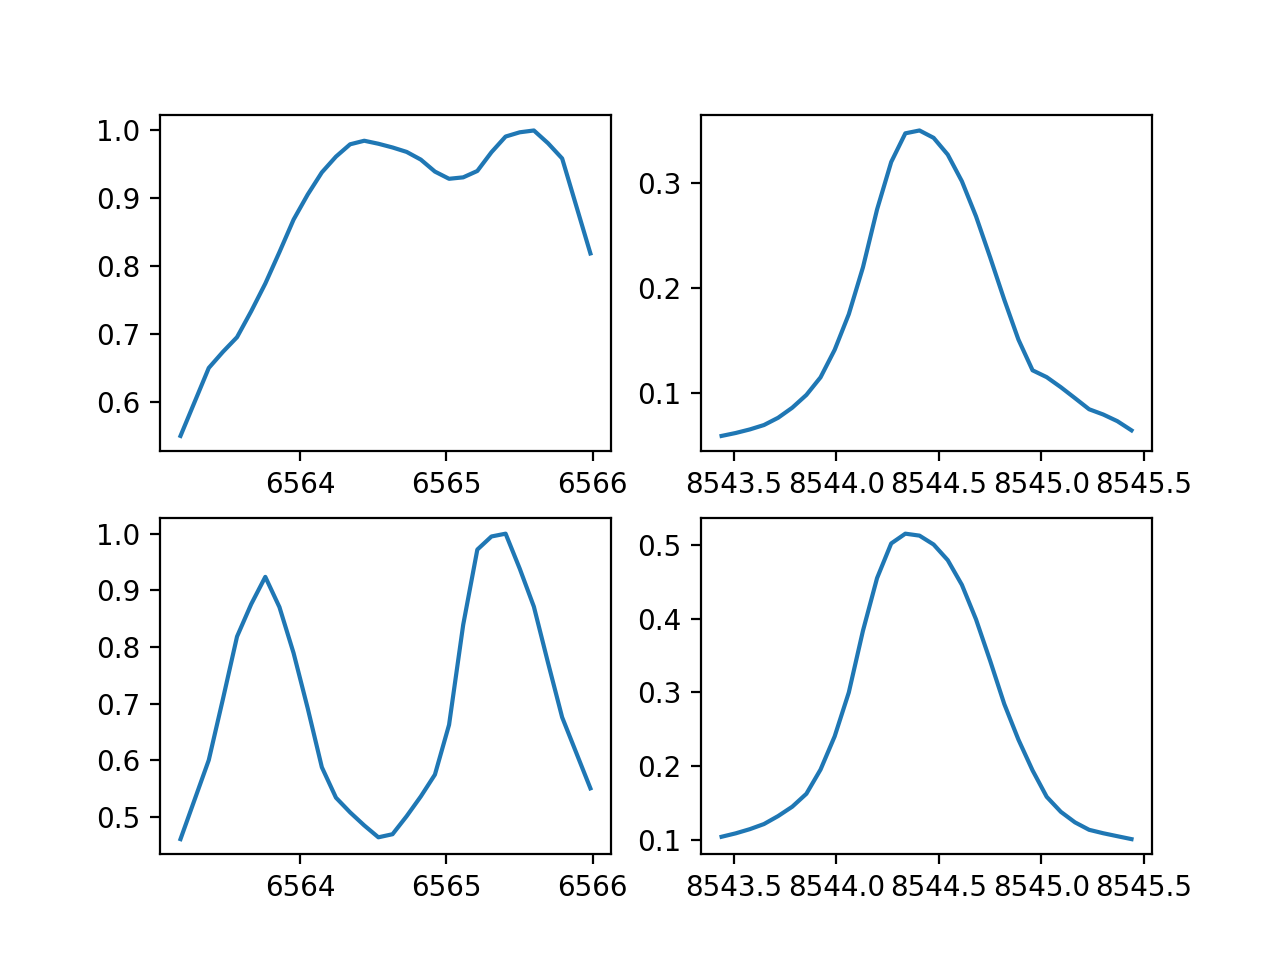

In [26]:
haGrid = haInput.reshape((wlLength, ha_data[0].shape[1], -1))
caGrid = caInput.reshape((wlLength, ca_data[0].shape[1], -1))

fig, ax = plt.subplots(2,2)
ax[0,0].plot(haInputWl, haGrid[:, grid_1[1],grid_1[0]])
ax[0,1].plot(caInputWl, caGrid[:, grid_1[1], grid_1[0]])
ax[1,0].plot(haInputWl, haGrid[:, grid_2[1], grid_2[0]])
ax[1,1].plot(caInputWl, caGrid[:, grid_2[1], grid_2[0]])

<IPython.core.display.Javascript object>


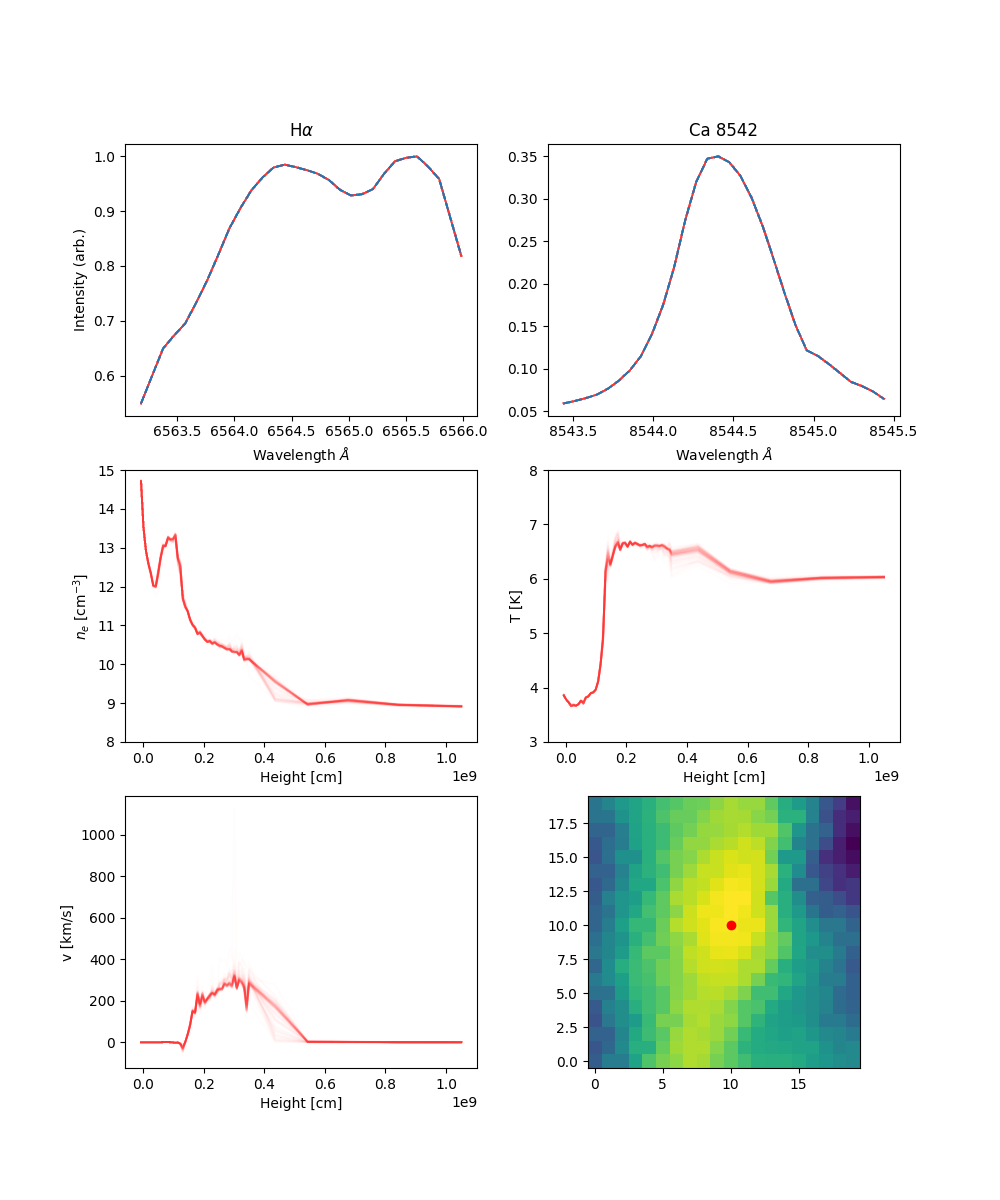

In [30]:
model.eval()
with torch.no_grad():
    batchSize = 100
    a = max(1.0 / batchSize, 0.002)
    y = torch.ones((batchSize, 2, wlLength))
    y[:, 0] *= torch.from_numpy(haGrid[:, grid_1[1], grid_1[0]]).float()
    y[:, 1] *= torch.from_numpy(caGrid[:, grid_1[1], grid_1[0]]).float()
    yz = model.outSchema.fill({'Halpha': y[:, 0] + 0.0 * torch.randn(y[:,0].shape), 'Ca8542': y[:, 1] + 0.0 * torch.randn(y[:,1].shape), 'LatentSpace': torch.randn})
    xOut = model(yz.to(dev), rev=True)
    yRoundTrip = model(xOut)
    
    vSign = xOut[:, model.inSchema.vel] / torch.abs(xOut[:, model.inSchema.vel])
    vSign[torch.isnan(vSign)] = 0
    vel = vSign * (10**torch.abs(xOut[:, model.inSchema.vel]) - 1.0)
    fig, ax = plt.subplots(3,2,figsize=(10,12))
    for i in range(batchSize):
        ax[1, 0].plot(data.z.numpy(), xOut[i, model.inSchema.ne].cpu().numpy(), c='r', alpha=a)
        ax[1, 1].plot(data.z.numpy(), xOut[i, model.inSchema.temperature].cpu().numpy(), c='r', alpha=a)
        ax[2, 0].plot(data.z.numpy(), vel[i].cpu().numpy(), c='r', alpha=a)
        ax[0, 0].plot(haInputWl, yRoundTrip[i, model.outSchema.Halpha].cpu().numpy(), c='r', alpha=a)
        ax[0, 1].plot(caInputWl, yRoundTrip[i, model.outSchema.Ca8542].cpu().numpy(), c='r', alpha=a)
        
    ax[0, 0].plot(haInputWl, yz[0, model.outSchema.Halpha].cpu().numpy(), '--')
    ax[0, 0].set_title(r'H$\alpha$')
    ax[0, 0].set_ylabel('Intensity (arb.)')
    ax[0,0].set_xlabel(r"Wavelength $\AA{}$")
    ax[0, 1].plot(caInputWl, yz[0, model.outSchema.Ca8542].cpu().numpy(), '--')
    ax[0, 1].set_title('Ca 8542')
    ax[0,1].set_xlabel(r"Wavelength $\AA{}$")
#     ax[1, 0].set_ylim(8, 17)
    ax[1, 0].set_ylim(8, 15)
    ax[1, 0].set_ylabel('$n_e$ [cm$^{-3}$]')
    ax[1,0].set_xlabel("Height [cm]")
    ax[1, 1].set_ylim(3, 8)
    ax[1, 1].set_ylabel('T [K]')
    ax[1,1].set_xlabel("Height [cm]")
    ax[2, 0].set_ylabel('v [km/s]')
#     ax[2,0].set_yscale("symlog")
    ax[2,0].set_xlabel("Height [cm]")
    ax[1,0].get_shared_x_axes().join(ax[1,0],ax[1,1],ax[2,0])

    ax[2,1].imshow(ha_data[haCentralIdx],origin="bottom")
    ax[2,1].plot(grid_1[0], grid_1[1], 'ro')
    fig.canvas.draw()
    fig.savefig("inv_onblob.png",dpi=300)

In [33]:
xOut.shape

torch.Size([100, 384])

In [39]:
model.inSchema

[('ne', 50), ('temperature', 50), ('vel', 50), ('!!ZeroPadding', 234)]

In [40]:
model.outSchema

[('LatentSpace', 150), ('!!ZeroPadding', 174), ('Halpha', 30), ('Ca8542', 30)]

In [38]:
yRoundTrip.shape

torch.Size([100, 384])

<IPython.core.display.Javascript object>


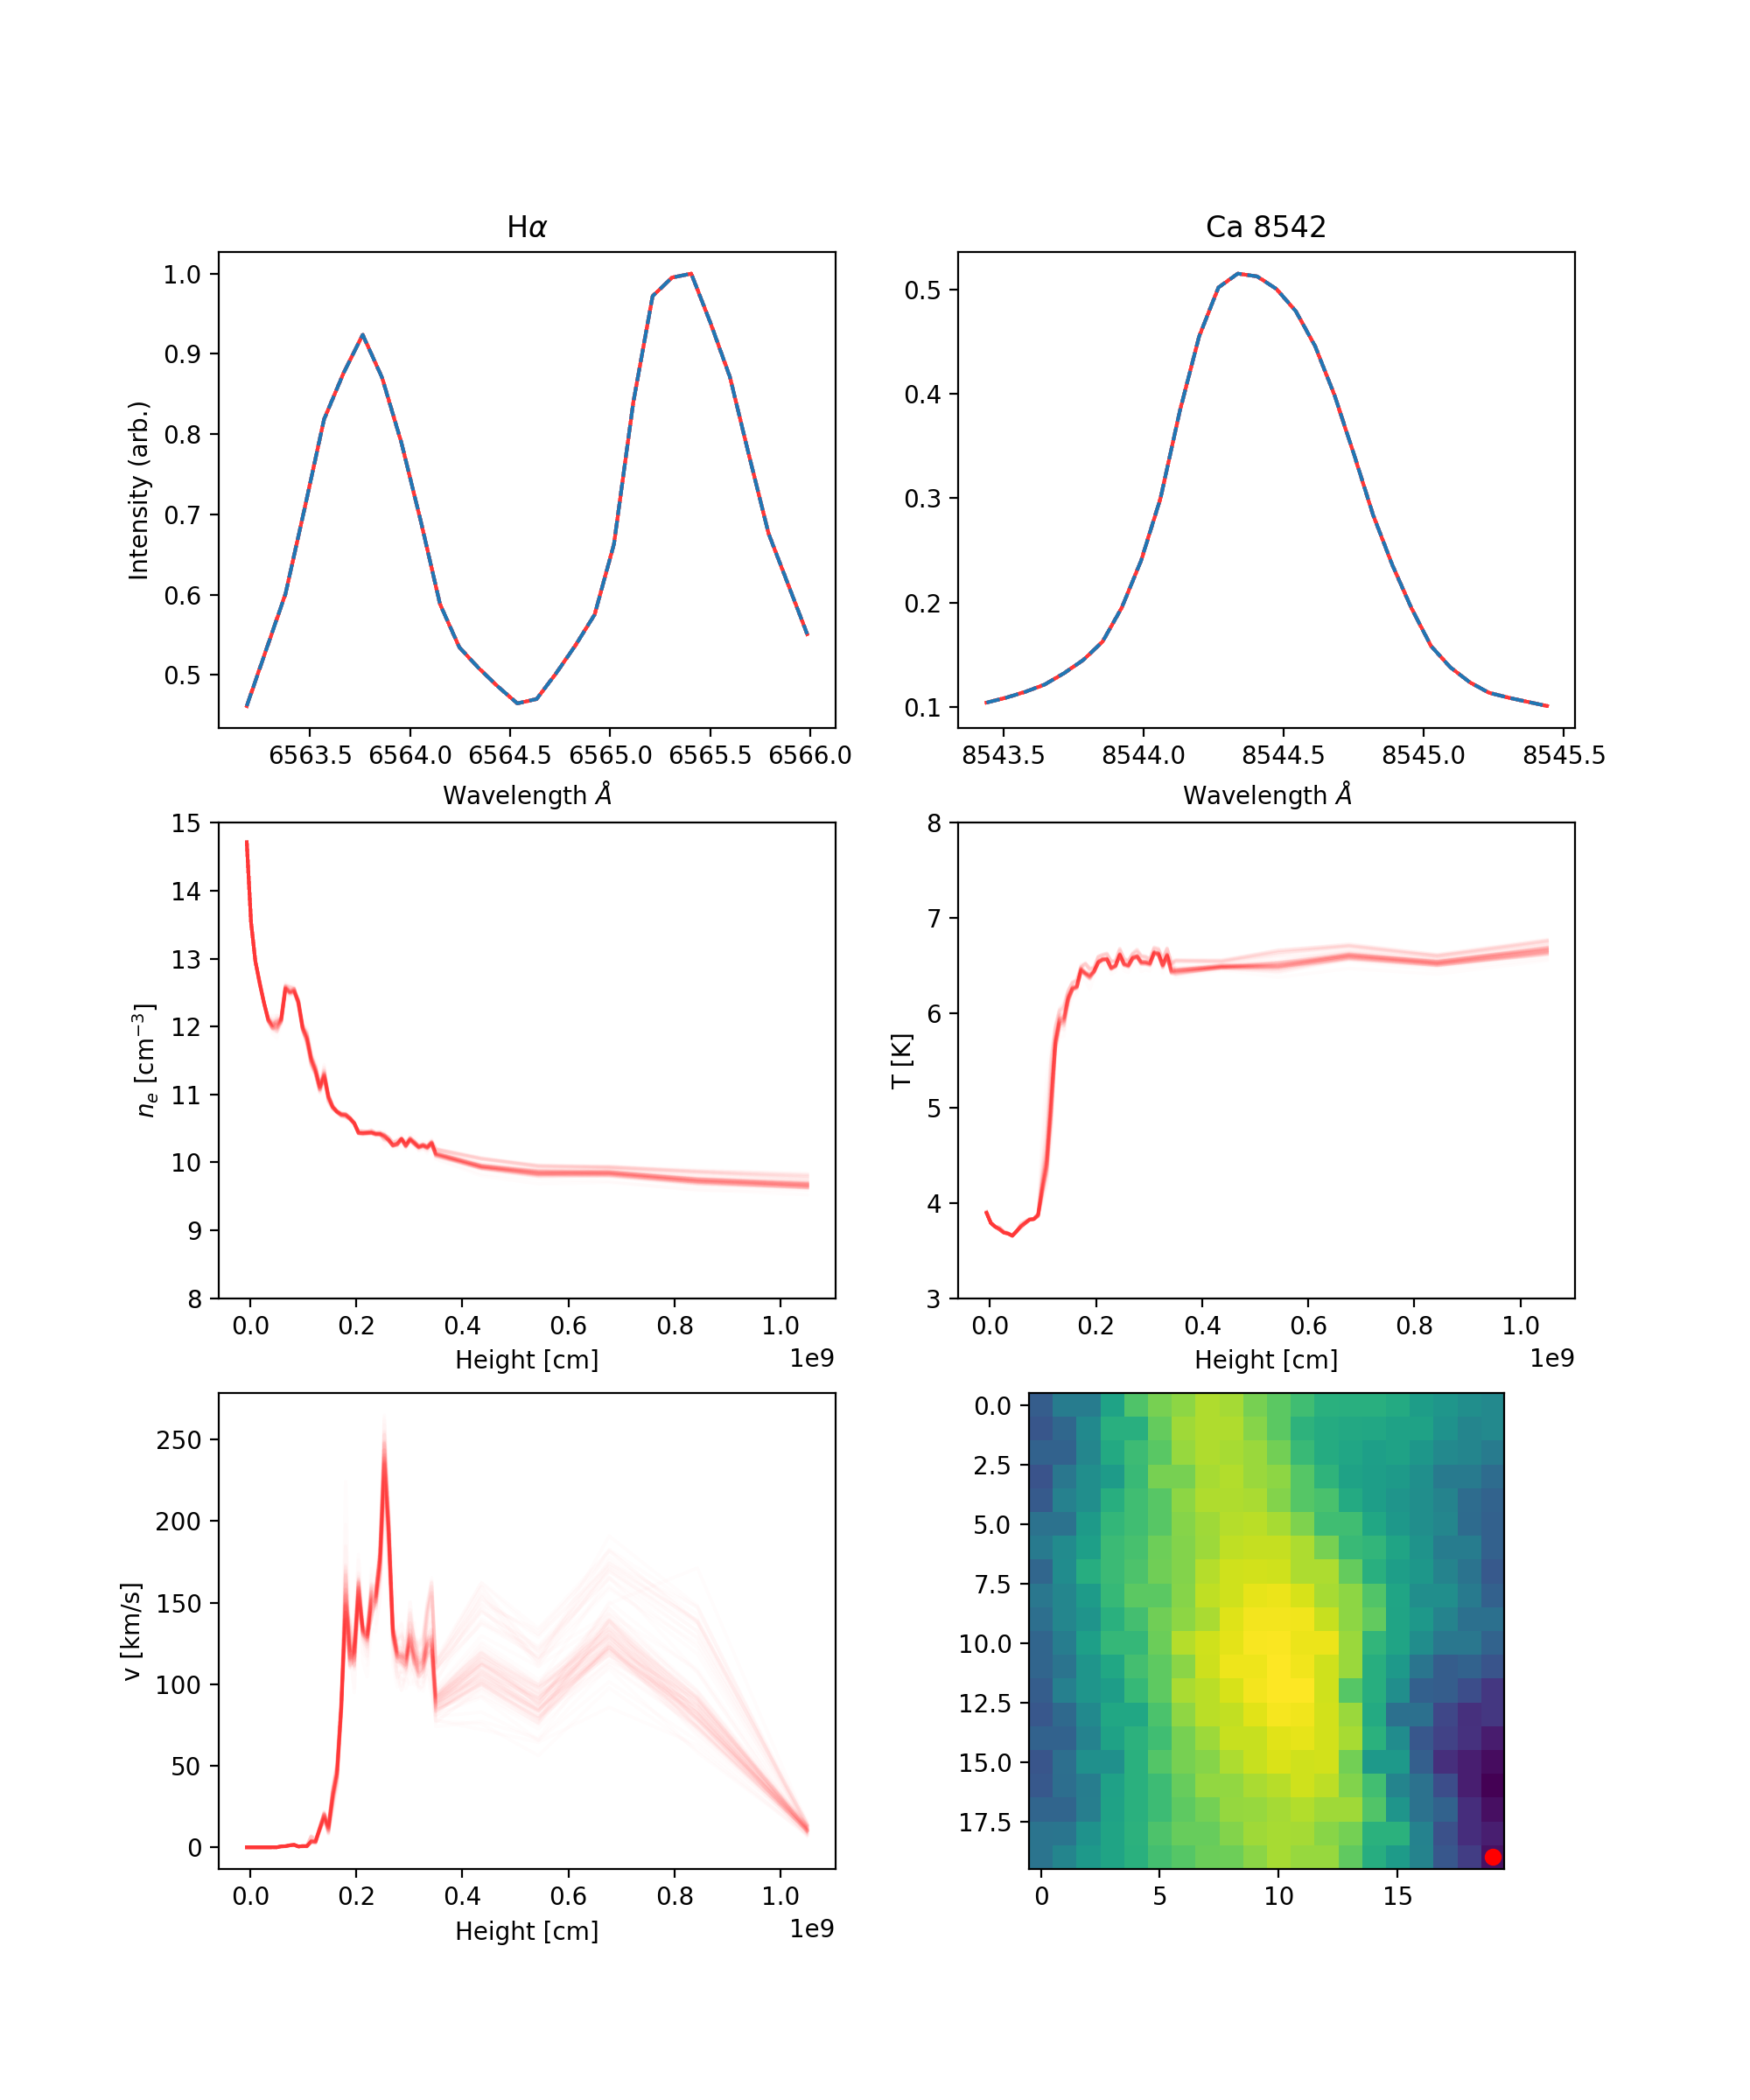

CPU times: user 3.15 s, sys: 1.11 s, total: 4.26 s
Wall time: 2.74 s


In [29]:
%%time
model.eval()
with torch.no_grad():
    batchSize = 100
    a = max(1.0 / batchSize, 0.002)
    y = torch.ones((batchSize, 2, wlLength))
    y[:, 0] *= torch.from_numpy(haGrid[:, grid_2[1], grid_2[0]]).float()
    y[:, 1] *= torch.from_numpy(caGrid[:, grid_2[1], grid_2[0]]).float()
    yz = model.outSchema.fill({'Halpha': y[:, 0] + 0.0 * torch.randn(y[:,0].shape), 'Ca8542': y[:, 1] + 0.0 * torch.randn(y[:,1].shape), 'LatentSpace': torch.randn})
    xOut = model(yz.to(dev), rev=True)
    yRoundTrip = model(xOut)
    
    vSign = xOut[:, model.inSchema.vel] / torch.abs(xOut[:, model.inSchema.vel])
    vSign[torch.isnan(vSign)] = 0
    vel = vSign * (10**torch.abs(xOut[:, model.inSchema.vel]) - 1.0)
    fig, ax = plt.subplots(3,2,figsize=(10,12))
    for i in range(batchSize):
        ax[1, 0].plot(data.z.numpy(), xOut[i, model.inSchema.ne].cpu().numpy(), c='r', alpha=a)
        ax[1, 1].plot(data.z.numpy(), xOut[i, model.inSchema.temperature].cpu().numpy(), c='r', alpha=a)
        ax[2, 0].plot(data.z.numpy(), vel[i].cpu().numpy(), c='r', alpha=a)
        ax[0, 0].plot(haInputWl, yRoundTrip[i, model.outSchema.Halpha].cpu().numpy(), c='r', alpha=a)
        ax[0, 1].plot(caInputWl, yRoundTrip[i, model.outSchema.Ca8542].cpu().numpy(), c='r', alpha=a)
        
    ax[0, 0].plot(haInputWl, yz[0, model.outSchema.Halpha].cpu().numpy(), '--')
    ax[0, 0].set_title(r'H$\alpha$')
    ax[0, 0].set_ylabel('Intensity (arb.)')
    ax[0,0].set_xlabel(r"Wavelength $\AA{}$")
    ax[0, 1].plot(caInputWl, yz[0, model.outSchema.Ca8542].cpu().numpy(), '--')
    ax[0, 1].set_title('Ca 8542')
    ax[0,1].set_xlabel(r"Wavelength $\AA{}$")
#     ax[1, 0].set_ylim(8, 17)
    ax[1, 0].set_ylim(8, 15)
    ax[1, 0].set_ylabel('$n_e$ [cm$^{-3}$]')
    ax[1,0].set_xlabel("Height [cm]")
    ax[1, 1].set_ylim(3, 8)
    ax[1, 1].set_ylabel('T [K]')
    ax[1,1].set_xlabel("Height [cm]")
    ax[2, 0].set_ylabel('v [km/s]')
    ax[2,0].set_xlabel("Height [cm]")
    ax[1,0].get_shared_x_axes().join(ax[1,0],ax[1,1],ax[2,0])

    ax[2,1].imshow(ha_data[haCentralIdx])
    ax[2,1].plot(grid_2[0], grid_2[1], 'ro')
    fig.canvas.draw()
    fig.savefig("inv_offblob.png",dpi=300)

In [ ]:
UniformColorMap = False


# imageIndices = [0, 10, 100, 500]
imageIndices = [420, 460, 482, 500, 515, 520, 540, 561] # indices chosen to have low seeing
roiX = range(300,1001)
roiY = range(600,1001)

# fineRoiX = range(495,506)
# fineRoiY = range(825,835)
# fineRoiX = range(395,405)
# fineRoiY = range(730,740)
# fineRoiX = range(663,665)
# fineRoiY = range(717,719)
fineRoiX = range(780,800)
fineRoiY = range(830,850)
boxSize = (fineRoiX[-1]-fineRoiX[0], fineRoiY[-1]-fineRoiY[0])

haTimes = []
caTimes = []
haData = []
caData = []
dataMinHa = 65536
dataMinCa = 65536
dataMaxHa = 0
dataMaxCa = 0

with fits.open(haFiles[0]) as hdu:
    haWl = hdu[1].data
    haCentreWl = hdu[0].header['TWAVE1']
    
with fits.open(caFiles[0]) as hdu:
    caWl = hdu[1].data
    caCentreWl = hdu[0].header['TWAVE1']

width = int(np.ceil(len(imageIndices)/2))
fig, ax = plt.subplots(4, width, figsize=(5 * width // 2,10), sharex=True, sharey=True)
ax = np.ravel(ax)
for j, i in enumerate(imageIndices):
    if j >= width:
        j += width

    with fits.open(haFiles[i]) as hdu:
        ha = hdu[0].data.astype(np.float64)
        haTime = hdu[0].header['DATE-AVG']
        haTimes.append(haTime)
        
    with fits.open(caFiles[i]) as hdu:
        ca = hdu[0].data.astype(np.float64)
        caTime = hdu[0].header['DATE-AVG']
        caTimes.append(caTime)
        
        
    haPatch = patches.Rectangle((fineRoiX[0], fineRoiY[0]), boxSize[0], boxSize[1], fill=False, color='r') 
    caPatch = patches.Rectangle((fineRoiX[0], fineRoiY[0]), boxSize[0], boxSize[1], fill=False, color='r') 

    trans = AffineTransform(rotation=angles[i], translation=translations[i])
    haTrans = [warp(ha[i], trans) for i in range(ha.shape[0])]
    haTrans = np.stack(haTrans)
    caTrans = [warp(ca[i], trans) for i in range(ca.shape[0])]
    caTrans = np.stack(caTrans)
    
    dataMinHa = min(dataMinHa, haTrans[haCentralIdx][np.ix_(roiX, roiY)].min())
    dataMinCa = min(dataMinCa, caTrans[caCentralIdx][np.ix_(roiX, roiY)].min())
    
    dataMaxHa = max(dataMaxHa, haTrans[haCentralIdx][np.ix_(roiX, roiY)].max())
    dataMaxCa = max(dataMaxCa, caTrans[caCentralIdx][np.ix_(roiX, roiY)].max())
    
    haData.append(haTrans[np.ix_(range(len(haWl)), fineRoiY, fineRoiX)])
    caData.append(caTrans[np.ix_(range(len(caWl)), fineRoiY, fineRoiX)])
#     ax[j].imshow(ha2[np.ix_(roiX, roiY)])
    ax[j].imshow(haTrans[haCentralIdx])
    ax[j].set_xlim(roiX[0], roiX[-1])
    ax[j].set_ylim(roiY[0], roiY[-1])
    ax[j].add_patch(haPatch)
    ax[j].set_xlabel(r'H$\alpha$ ' + haTime[11:])
    
    ax[j+width].imshow(caTrans[caCentralIdx])
    ax[j+width].set_xlim(roiX[0], roiX[-1])
    ax[j+width].set_ylim(roiY[0], roiY[-1])
    ax[j+width].add_patch(caPatch)
    ax[j+width].set_xlabel('Ca 8542 ' + caTime[11:])
    
if UniformColorMap:
    dataMin = min(dataMinHa, dataMinCa)
    dataMax = max(dataMaxHa, dataMaxCa)
    for j, i in enumerate(imageIndices):
        if j >= width:
            j += width

        [im.set_clim(vmin=dataMin, vmax=dataMax) for im in ax[j].get_images()]
        [im.set_clim(vmin=dataMin, vmax=dataMax) for im in ax[j+width].get_images()]

    
# cbAxis = fig.add_axes([0.1, 0.03, 0.8, 0.03]) 
# fig.colorbar(ax[0].get_images()[0], orientation='horizontal', cax=cbAxis)
fig.tight_layout()
fig.canvas.draw()



In [ ]:
UniformColorMap = False

width = int(np.ceil(len(imageIndices)/2))
fig, ax = plt.subplots(4, width, figsize=(5 * width // 2,10), sharex=True, sharey=True)
ax = np.ravel(ax)
gridMax = max([h[haCentralIdx].max() for h in haData] + [c[caCentralIdx].max() for c in caData])
gridMin = min([h[haCentralIdx].min() for h in haData] + [c[caCentralIdx].min() for c in caData])

if not UniformColorMap:
    gridMax = None
    gridMin = None

for j, i in enumerate(imageIndices):
    plotIdx = j + width if j >= width else j
        
    ax[plotIdx].imshow(haData[j][haCentralIdx], vmin=gridMin, vmax=gridMax)
    ax[plotIdx+width].imshow(caData[j][caCentralIdx], vmin=gridMin, vmax=gridMax)
    ax[plotIdx].set_xlabel(r'H$\alpha$: ' + haTimes[j][11:])
    ax[plotIdx+width].set_xlabel('Ca 8542: ' + caTimes[j][11:])

In [ ]:

# gridIdx, gridX, gridY = 0, 17, 15
# gridX2, gridY2 = 9, 1

gridIdx, gridX, gridY = 2, 5, 13
gridX2, gridY2 = 19, 15

# gridIdx, gridX, gridY = 1, 10, 17
# gridX2, gridY2 = 6, 5

# gridIdx, gridX, gridY = 4, 6, 12
# gridX2, gridY2 = 18, 3

# gridIdx, gridX, gridY = 2, 1, 11
# gridX2, gridY2 = 16, 2

# gridIdx, gridX, gridY = 5, 1, 17
# gridX2, gridY2 = 11, 2


In [ ]:
from scipy.interpolate import interp1d
wlLength = 30
haFlat = [np.reshape(h, (h.shape[0],-1)) for h in haData]
caFlat = [np.reshape(c, (c.shape[0],-1)) for c in caData]

haInput = [np.zeros((wlLength, h.shape[1])) for h in haFlat]
caInput = [np.zeros((wlLength, c.shape[1])) for c in caFlat]

haInputWl = np.linspace(haCentreWl - haHW, haCentreWl + haHW, num=30) 
caInputWl = np.linspace(caCentreWl - caHW, caCentreWl + caHW, num=30) 

for i in range(len(haFlat)):
    for j in range(haFlat[i].shape[1]):
        haInterp = interp1d(haWl, haFlat[i][:,j], kind='linear')
        caInterp = interp1d(caWl, caFlat[i][:,j], kind='linear')
        
        haInput[i][:,j] = haInterp(haInputWl)
        caInput[i][:,j] = caInterp(caInputWl)


peakEmission = [np.zeros(h.shape[1]) for h in haFlat]
for i in range(len(haFlat)):
    for j in range(haFlat[i].shape[1]):
        peakEmission[i][j] = max(np.amax(haInput[i][:,j]), np.amax(caInput[i][:,j]))
        haInput[i][:,j] /= peakEmission[i][j]
        caInput[i][:,j] /= peakEmission[i][j]
        

In [ ]:
haGrid = [h.reshape((wlLength, haData[0].shape[1], -1)) for h in haInput]
caGrid = [c.reshape((wlLength, caData[0].shape[1], -1)) for c in caInput]

fig, ax = plt.subplots(2,2)
ax[0,0].plot(haInputWl, haGrid[gridIdx][:, gridY, gridX])
# ax[0,0].plot(haWl, haData[gridIdx][:, gridY, gridX] / haData[gridIdx][:, gridY, gridX].max())
ax[0,1].plot(caInputWl, caGrid[gridIdx][:, gridY, gridX])
# ax[0,1].plot(caWl, caData[gridIdx][:, gridY, gridX] / caData[gridIdx][:, gridY, gridX].max())
ax[1,0].plot(haInputWl, haGrid[gridIdx][:, gridY2, gridX2])
# ax[1,0].plot(haWl, haData[gridIdx][:, gridY2, gridX2] / haData[gridIdx][:, gridY2, gridX2].max())
ax[1,1].plot(caInputWl, caGrid[gridIdx][:, gridY2, gridX2])
# ax[1,1].plot(caWl, caData[gridIdx][:, gridY2, gridX2] / caData[gridIdx][:, gridY2, gridX2].max())

In [ ]:
model.eval()
with torch.no_grad():
    batchSize = 100
    a = max(1.0 / batchSize, 0.002)
    y = torch.ones((batchSize, 2, wlLength))
    y[:, 0] *= torch.from_numpy(haGrid[gridIdx][:, gridY, gridX]).float()
    y[:, 1] *= torch.from_numpy(caGrid[gridIdx][:, gridY, gridX]).float()
    yz = model.outSchema.fill({'Halpha': y[:, 0] + 0.0 * torch.randn(y[:,0].shape), 'Ca8542': y[:, 1] + 0.0 * torch.randn(y[:,1].shape), 'LatentSpace': torch.randn})
    xOut = model(yz.to(dev), rev=True)
    yRoundTrip = model(xOut)
    
    vSign = xOut[:, model.inSchema.vel] / torch.abs(xOut[:, model.inSchema.vel])
    vSign[torch.isnan(vSign)] = 0
    vel = vSign * (10**torch.abs(xOut[:, model.inSchema.vel]) - 1.0)
    fig, ax = plt.subplots(3,2)
    for i in range(batchSize):
        ax[1, 0].plot(data.z.numpy(), xOut[i, model.inSchema.ne].cpu().numpy(), c='r', alpha=a)
        ax[1, 1].plot(data.z.numpy(), xOut[i, model.inSchema.temperature].cpu().numpy(), c='r', alpha=a)
        ax[2, 0].plot(data.z.numpy(), vel[i].cpu().numpy(), c='r', alpha=a)
        ax[0, 0].plot(haInputWl, yRoundTrip[i, model.outSchema.Halpha].cpu().numpy(), c='r', alpha=a)
        ax[0, 1].plot(caInputWl, yRoundTrip[i, model.outSchema.Ca8542].cpu().numpy(), c='r', alpha=a)
        
    ax[0, 0].plot(haInputWl, yz[0, model.outSchema.Halpha].cpu().numpy(), '--')
    ax[0, 0].set_title(r'H$\alpha$')
    ax[0, 0].set_ylabel('Intensity (arb.)')
    ax[0, 1].plot(caInputWl, yz[0, model.outSchema.Ca8542].cpu().numpy(), '--')
    ax[0, 1].set_title('Ca 8542')
#     ax[1, 0].set_ylim(8, 17)
    ax[1, 0].set_ylim(8, 15)
    ax[1, 0].set_ylabel('$n_e$ [cm$^{-3}$]')
    ax[1, 1].set_ylim(3, 8)
    ax[1, 1].set_ylabel('T [K]')
    ax[2, 0].set_ylabel('v [km/s]')
    ax[1,0].get_shared_x_axes().join(ax[1,0],ax[1,1],ax[2,0])

    ax[2,1].imshow(haData[gridIdx][haCentralIdx])
    ax[2,1].plot(gridX, gridY, 'ro')
    fig.canvas.draw()

In [ ]:
model.eval()
with torch.no_grad():
    batchSize = 100
    a = max(1.0 / batchSize, 0.002)
    y = torch.ones((batchSize, 2, wlLength))
    y[:, 0] *= torch.from_numpy(haGrid[gridIdx][:, gridY2, gridX2]).float()
    y[:, 1] *= torch.from_numpy(caGrid[gridIdx][:, gridY2, gridX2]).float()
    yz = model.outSchema.fill({'Halpha': y[:, 0] + 0.0 * torch.randn(y[:,0].shape), 'Ca8542': y[:, 1] + 0.0 * torch.randn(y[:,1].shape), 'LatentSpace': torch.randn})
    xOut = model(yz.to(dev), rev=True)
    yRoundTrip = model(xOut)
    
    vSign = xOut[:, model.inSchema.vel] / torch.abs(xOut[:, model.inSchema.vel])
    vSign[torch.isnan(vSign)] = 0
    vel = vSign * (10**torch.abs(xOut[:, model.inSchema.vel]) - 1.0)
    fig, ax = plt.subplots(3,2)
    for i in range(batchSize):
        ax[1, 0].plot(data.z.numpy(), xOut[i, model.inSchema.ne].cpu().numpy(), c='r', alpha=a)
        ax[1, 1].plot(data.z.numpy(), xOut[i, model.inSchema.temperature].cpu().numpy(), c='r', alpha=a)
        ax[2, 0].plot(data.z.numpy(), vel[i].cpu().numpy(), c='r', alpha=a)
        ax[0, 0].plot(haInputWl, yRoundTrip[i, model.outSchema.Halpha].cpu().numpy(), c='r', alpha=a)
        ax[0, 1].plot(caInputWl, yRoundTrip[i, model.outSchema.Ca8542].cpu().numpy(), c='r', alpha=a)
        
    ax[0, 0].plot(haInputWl, yz[0, model.outSchema.Halpha].cpu().numpy(), '--')
    ax[0, 0].set_title(r'H$\alpha$')
    ax[0, 0].set_ylabel('Intensity (arb.)')
    ax[0, 1].plot(caInputWl, yz[0, model.outSchema.Ca8542].cpu().numpy(), '--')
    ax[0, 1].set_title('Ca 8542')
#     ax[1, 0].set_ylim(8, 17)
    ax[1, 0].set_ylim(8, 15)
    ax[1, 0].set_ylabel('$n_e$ [cm$^{-3}$]')
    ax[1, 1].set_ylim(3, 8)
    ax[1, 1].set_ylabel('T [K]')
    ax[2, 0].set_ylabel('v [km/s]')
    ax[1,0].get_shared_x_axes().join(ax[1,0],ax[1,1],ax[2,0])

    ax[2,1].imshow(haData[gridIdx][haCentralIdx])
    ax[2,1].plot(gridX2, gridY2, 'ro')
    fig.canvas.draw()